描述性统计：
               mean   median         std
gravity    1.017894    1.018    0.006675
ph         5.955459    5.740    0.642260
osmo     651.545894  679.500  234.676567
cond      21.437923   22.200    7.514750
urea     278.657005  277.000  136.442249
calc       4.114638    3.130    3.217641


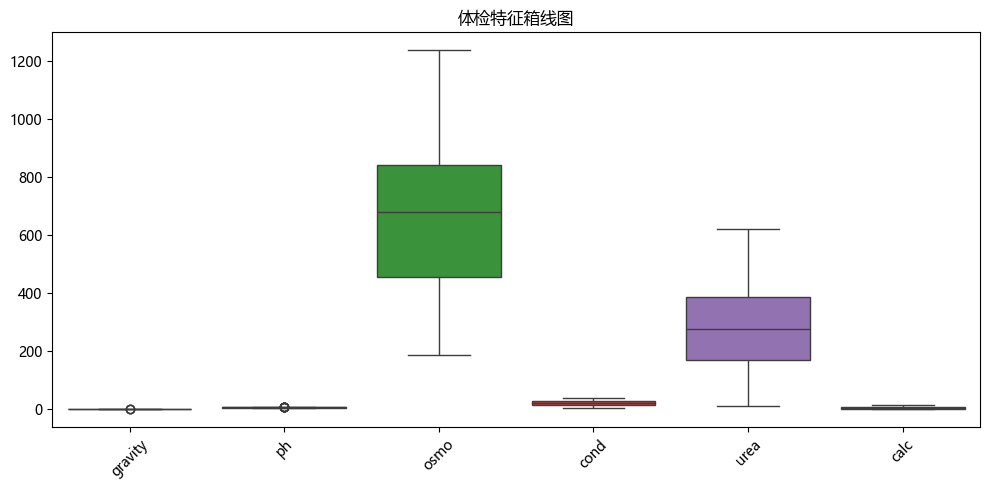


与肾结石相关的皮尔逊系数：
calc       0.467439
gravity    0.282577
urea       0.265211
osmo       0.244770
cond       0.172224
ph        -0.094983
Name: target, dtype: float64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
# 设置中文字体
rcParams['font.family'] = 'Microsoft YaHei'
# 读取训练数据
train_df = pd.read_csv("train.csv")
features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

# 描述性统计
summary = train_df[features].agg(['mean', 'median', 'std']).T
print("描述性统计：")
print(summary)

# 箱线图查看异常值
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df[features])
plt.title("体检特征箱线图")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 计算相关性（与 target）
corr = train_df[features + ['target']].corr()['target'].drop('target')
print("\n与肾结石相关的皮尔逊系数：")
print(corr.sort_values(ascending=False))


# 第二问

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score

# 特征和标签
X = train_df[features]
y = train_df['target']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 模型一：逻辑回归
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred1 = logit.predict(X_val)

# 模型二：随机森林
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_val)

# 评估指标输出
def print_metrics(y_true, y_pred, name):
    print(f"\n模型：{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:  ", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

print_metrics(y_val, y_pred1, "逻辑回归")
print_metrics(y_val, y_pred2, "随机森林")

# 读取测试集并预测
test_df = pd.read_csv("test.csv")
X_test_scaled = scaler.transform(test_df[features])
y_test_pred = rf.predict(X_test_scaled)

# 生成提交文件
sub = pd.read_csv("sample_submission.csv")
sub['target'] = y_test_pred
sub.to_csv("cla_pre.csv", index=False)
print("\n 预测结果已保存为 cla_pre.csv")



模型：逻辑回归
Accuracy: 0.7831325301204819
Recall:   0.7105263157894737
F1 Score: 0.7499999999999999

模型：随机森林
Accuracy: 0.7710843373493976
Recall:   0.7631578947368421
F1 Score: 0.7532467532467534

 预测结果已保存为 cla_pre.csv


c:\Program Files\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [00:16:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 800x500 with 0 Axes>

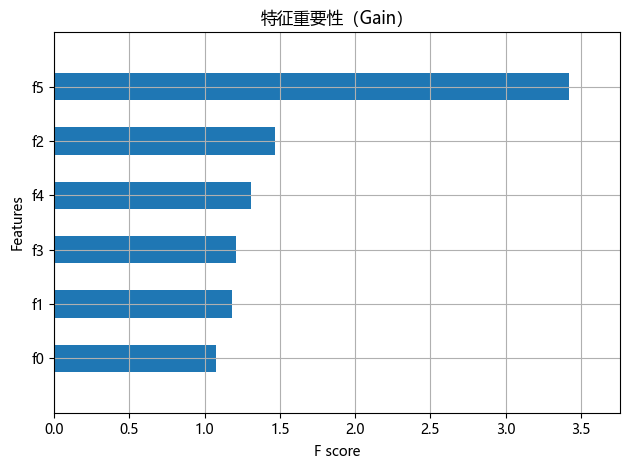

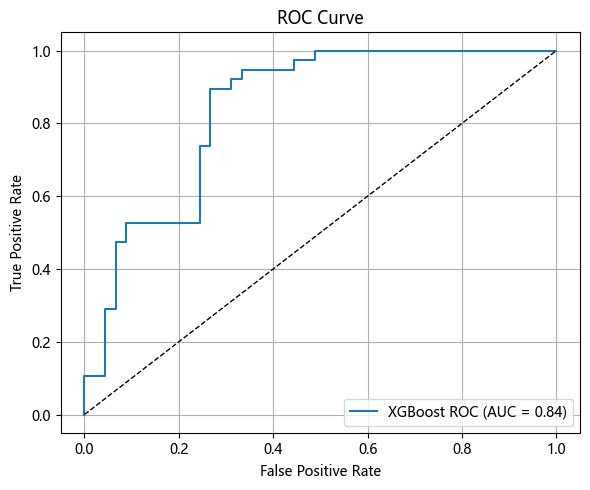

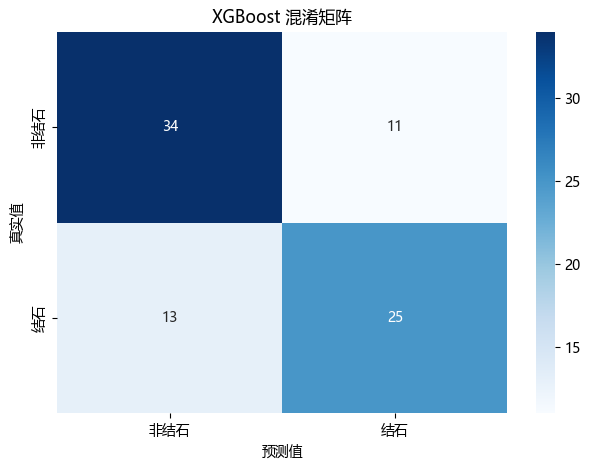

Accuracy: 0.7108433734939759
Recall:   0.6578947368421053
F1 Score: 0.6756756756756757
已保存 gfboost_submission.csv 文件


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, recall_score
from xgboost import XGBClassifier, plot_importance
import numpy as np

# 读取数据
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
X = train_df[features]
y = train_df['target']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test_df[features])

# 划分训练集与验证集
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 构建 XGBoost 模型
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=4, learning_rate=0.1, n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)
y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# ------------------ 图像 1: 特征重要性 ------------------
plt.figure(figsize=(8, 5))
plot_importance(xgb_model, importance_type='gain', height=0.5, show_values=False)
plt.title("特征重要性（Gain）")
plt.tight_layout()
plt.show()

# ------------------ 图像 2: ROC 曲线 ------------------
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

# ------------------ 图像 3: 混淆矩阵 ------------------
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["非结石", "结石"], yticklabels=["非结石", "结石"])
plt.xlabel("预测值")
plt.ylabel("真实值")
plt.title("XGBoost 混淆矩阵")
plt.tight_layout()
plt.show()

# ------------------ 输出评估指标 ------------------
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Recall:  ", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

# ------------------ 保存预测结果 ------------------
sample = pd.read_csv("sample_submission.csv")
sample['target'] = xgb_model.predict(X_test_scaled)
sample.to_csv("gfboost_submission.csv", index=False)
print("已保存 gfboost_submission.csv 文件")
